# Import useful libraries

In [1]:
# Import useful system libraries
import os
import sys
import distutils.util
import argparse

# Import data useful libraries
import pandas as pd
import numpy as np
import anndata
import scanpy as sc

# Import useful functions
sys.path.append('../')
from batchaif.training_functions import run_batch_effect_pipeline
from batchaif.models import CVAE, Discriminator, Auxiliary

/Users/lily/Documents/MICS/batchaif/batchaif_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining useful paths

In [3]:
# Retrieving useful environments variables
work_dir = '..'          # Working directory where the data is stored
file_name = 'dataset_1'  # Dataset name
model_name = 'aif_proj_boost_norm_log_rel_dyn_aux_dis_delayed_decay_exp' # Model name

# Dataset path, file's name and outputs directory name
root = f'{work_dir}/InData'
data_file = f'{work_dir}/data_preprocessed/{file_name}_norm_log.csv'
experiment_path = f'{work_dir}/Experiments'
results_path = f'{experiment_path}/{file_name}'
out_dir = f'{results_path}/single_run_analysis'

# Defining useful variables

## Models architecture

In [4]:
# Defining the model's specifications
nz = 100                            # Dimension of latent space

# CVAE
cvae_hidden_units = [800, 800]      # CVAE layers' hidden units
sigma = 1                           # Latent space variance for normal distribution
cvae_activation = 'ReLU'            # CVAE activation functions
norm = True                         # Adding batch normalization layers

# Discriminator
dis_hidden_units = [800, 800]       # Discriminator layers' hidden units
dis_activation = 'ReLU'             # Discriminator activation functions

# Auxiliary
aux_hidden_units = [800, 800]       # Auxiliary layers' hidden units
aux_activation = 'ReLU'             # Auxiliary activation functions

## Training hyperparameters

In [5]:
# Defining training hyperparameters
epochs = 1500                   # Epochs
lr = 0.01                       # Learning rate
batch_size = 32                 # Batch size
beta_1 = 0.8                    # Beta 1 for ADAM optimizer
beta_2 = 0.95                   # Beta 2 for ADAM optimizer

# Losses' hyperparameters
losses_enc_weights = {'mse': 1, 'kl': 0.05, 'class': 0.5, 'class_rec': 0.05, 'aux': 0.3, 'gen': 0.1, 'proj': 0.1}

# Defining optimization parameters
norm_data = True                    # Whether to use normalized data
log_transfo = True                  # Whether to use log1p transformation
min_epochs = int(0.9 * epochs)      # Minimum number of epochs for early stopping
weighting_strategy = 'rel'          # Weighting strategy to use
dynamic_ratio = 0.1                 # Percentage of the data to use for dynamic reweighting
update_aux_freq = 1/300             # Frequency at which to update the auxiliary network
update_dis_freq = 1/300             # Frequency at which to update the GAN network
scheduler = 'exponentional'         # Method to use for decaying the learning rate
start_decay = int(0.2 * epochs)     # Epoch when to start decaying the learning rate
decay_factor = 0.999                # Decay factor for exponentional decay
projection_constraint = {'random': True,    # Projection constraint to use
                         'avg': True}

## Other useful variables

In [6]:
# Defining other useful variables
cell_type_key = 'cell_type'         # Cell type key in adata
batch_key = 'batch'                 # Batch key in adata
label_projection = 0                # Batch label used for projection
test = False                        # Whether to evaluate the model on the test set
save = {'cvae': True,               # Saving specifications
        'aux': False,
        'dis': False,
        'loss': True,
        'corrected_data': True,
        'time': True}
verbose = False                     # Verbosity
seed = 42
device = 'cuda'

# Defining colors
colors_batch = ['#24bca8', '#448ee4', '#cb0162', '#fc824a', '#ffda03']
colors_cell_types = ['tab:blue',
                     'tab:orange',
                     'tab:green',
                     'tab:red']

# Creating useful directories

In [7]:
# Creating outputs directory
if not os.path.isdir(experiment_path):
    os.mkdir(experiment_path)
if not os.path.isdir(results_path):
    os.mkdir(results_path)
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
if not (os.path.isdir(f'{out_dir}/{model_name}')):
    os.mkdir(f'{out_dir}/{model_name}')

# Importing data

In [8]:
# Importing original data
data = pd.read_csv(data_file, index_col=0, header=0)
# Creating annotated matrix in AnnData format with expression matrix
adata = anndata.AnnData(X=np.array(data.iloc[:, :-2]))
# Adding cell type and batch as observations
adata.obs[cell_type_key] = data[cell_type_key].tolist()
adata.obs[batch_key] = data[batch_key].tolist()

# Retrieving the number of batch labels and the input size
n_labels = len(data[batch_key].unique())
input_size = len(data.columns) - 2

# Creating model

In [9]:
# Creating the model
model = {'cvae': CVAE(nz=nz, input_size=input_size, hidden_units=cvae_hidden_units, sigma=sigma,
                      activation=cvae_activation, norm=norm, n_labels=n_labels),
         'dis': Discriminator(input_size=input_size, hidden_units=dis_hidden_units, activation=dis_activation),
         'aux': Auxiliary(nz=nz, hidden_units=aux_hidden_units,
                          activation=aux_activation, n_labels=n_labels)}

# Running the batch effect correction pipeline

In [ ]:
# Running the batch effect removal pipeline
corrected_adata = run_batch_effect_pipeline(model=model, adata=adata, batch_size=batch_size, epochs=epochs, 
                                            lr=lr, beta_1=beta_1, beta_2=beta_2, root=root, 
                                            results_path=out_dir, file_name=file_name, model_name=model_name,
                                            losses_enc_weights=losses_enc_weights, weighting_strategy=weighting_strategy,
                                            dynamic_ratio=dynamic_ratio, projection_constraint=projection_constraint, 
                                            scheduler=scheduler, start_decay=start_decay, decay_factor=decay_factor, 
                                            update_dis_freq=update_dis_freq, update_aux_freq=update_aux_freq,
                                            norm_data=norm_data, log_transfo=log_transfo, label_projection=label_projection, 
                                            n_labels=n_labels, save=save, verbose=verbose, min_epochs=min_epochs,
                                            seed=seed, device=device)

Prepare data loaders ...
Data loaders ready.

Trying batch size=32, lr=0.01, beta1=0.8, beta2=0.95
Resetting weights ...
Creating optimizers ...
Training model ...
Final total loss:     4.040279458826667e-05
Best total loss:     3.8639207761864076e-05
Retrieving best model ...


# Showing results

## Defining colors

In [15]:
# Defining colors
colors_batch = ['#24bca8', '#448ee4', '#cb0162', '#fc824a', '#ffda03']
colors_cell_types = ['tab:blue',
                     'tab:orange',
                     'tab:green',
                     'tab:red']

# Retrieving unique batch labels and cell type labels
batch_labels = data[batch_key].unique()
batch_labels.sort()
cell_type_labels = data[cell_type_key].unique().tolist()
cell_type_labels.sort(key=lambda y: y.lower())

# Mapping colors to cell type and batch labels
colors_cell_types_dict = dict(zip(cell_type_labels, colors_cell_types[::int(len(colors_cell_types) /
                                                                            len(cell_type_labels))]))
colors_batch_dict = dict(zip(batch_labels, colors_batch[::int(len(colors_batch) / len(batch_labels))]))

# Adding colors to corrected adata
corrected_adata.uns['cell_type_colors'] = colors_cell_types_dict
corrected_adata.uns['batch_colors'] = colors_batch_dict

## t-SNE visualization 

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/lily/Documents/MICS/batchaif/batchaif_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


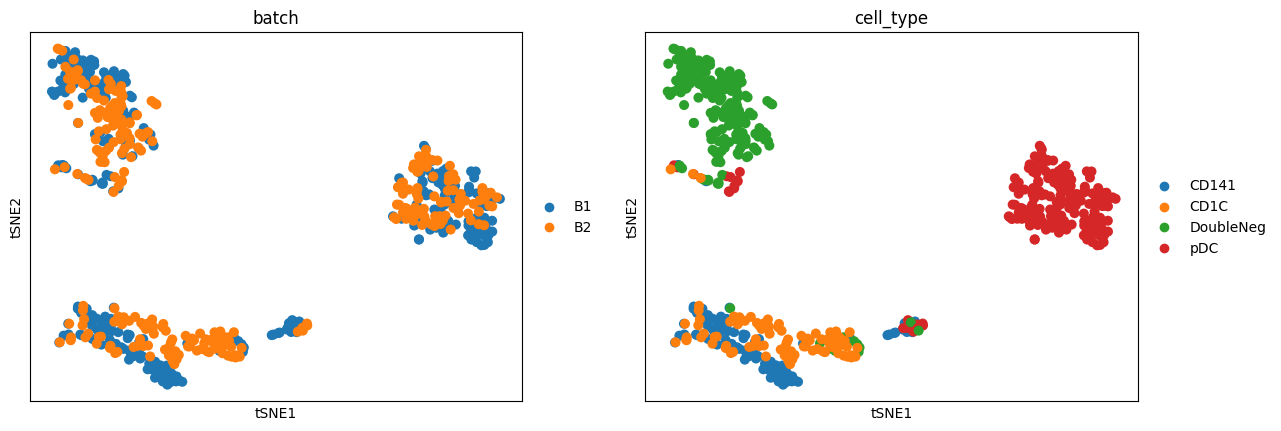

In [16]:
sc.tl.tsne(corrected_adata)
sc.pl.tsne(corrected_adata, color=['batch', 'cell_type'])

## UMAP visualization

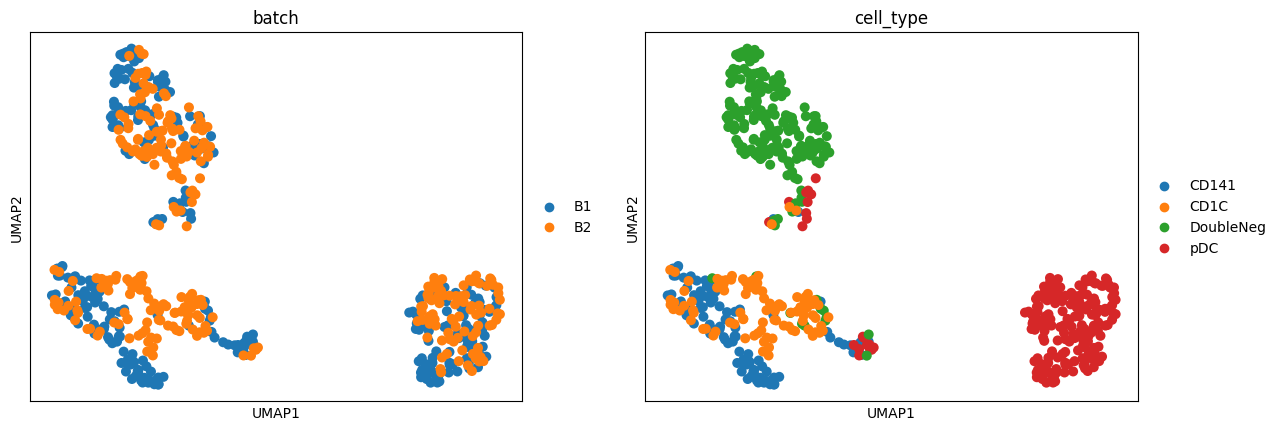

In [17]:
sc.pp.neighbors(corrected_adata, use_rep='X')
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'])